In [3]:
import os
import pickle
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, "..")
from paths import *
from neo4j import GraphDatabase, basic_auth
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [4]:
pval_thresh = 0.05
compound_type = "combined"
sample = "feces"
sel_sheet_index = 2

filename = "top_nodes_for_each_nodetype_for_{}_compounds_{}_sample_sheet_index_{}_list.pickle".format(compound_type, sample, str(sel_sheet_index))


In [7]:
with open(os.path.join(OUTPUT_PATH, "after_spoke_compound_pruning", filename), "rb") as f:
    top_nodes = pickle.load(f)
    

In [8]:
def get_node_names(nodes_df):
    auth = basic_auth(SPOKE_USER, SPOKE_PASSWORD)
    sdb = GraphDatabase.driver(URI, auth=auth)
    node_type = nodes_df["node_type"].unique()[0]
    if node_type != "Variant" and node_type != "MiRNA" and node_type != "Reaction" and node_type != "EC":
        if  node_type == "Gene" or node_type == "Organism":
            query = """
                        MATCH(n:{})
                        WHERE n.identifier = {}
                        RETURN n.name AS n_name
            """
        else:
            query = """
                        MATCH(n:{})
                        WHERE n.identifier = '{}'
                        RETURN n.name AS n_name
            """
        node_list = []
        with sdb.session() as session:
            with session.begin_transaction() as tx:
                for index, row in nodes_df.iterrows():
                    result = tx.run(query.format(row["node_type"], row["node_id"]))
                    for row_ in result:
                        node_list.append((row["node_id"], row_["n_name"], row["node_type"]))
        sdb.close()
        nodes_df_ = pd.DataFrame(node_list, columns = ["node_id", "node_name", "node_type"])    
        return pd.merge(nodes_df, nodes_df_, on=["node_id", "node_type"], how="left")
    else:
        nodes_df["node_name"] = nodes_df["node_id"]
        return nodes_df


def plot_figure(top_negative_nodes_, top_positive_nodes_, save=False):
    logpval_thresh = -np.log10(pval_thresh)
    FONTSIZE = 12

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    if top_negative_nodes_.shape[0] != 0:
        nodetype = top_negative_nodes_.node_type.unique()[0]
        ax1.bar(top_negative_nodes_['node_name'], top_negative_nodes_['log_p'], color="r")
        ax1.set_xticklabels(top_negative_nodes_['node_name'], rotation=45, ha='right', fontsize=FONTSIZE)
        ax1.set_ylabel('MS proximity (-log10 pvalue)')
        # ax2.set_title('Top Negative value nodes')
        ax1.axhline(y=logpval_thresh, color='blue', linestyle='--')

    if top_positive_nodes_.shape[0] != 0:
        nodetype = top_positive_nodes_.node_type.unique()[0]
        ax2.bar(top_positive_nodes_['node_name'], top_positive_nodes_['log_p'], color="g")
        ax2.set_xticklabels(top_positive_nodes_['node_name'], rotation=45, ha='right', fontsize=FONTSIZE)
        # ax2.set_ylabel('-log10(p)')
        # ax1.set_title('Top Positive value nodes')
        ax2.axhline(y=logpval_thresh, color='blue', linestyle='--')

    # Set the layout and show the plot
    fig.suptitle(f'{nodetype}', fontsize=13)
    fig.tight_layout()
    plt.show()
    if save:
        print("Saving figure ...")
        filename = "{}_compounds_{}_sample_sheet_index_{}_{}_nodetype.svg".format(compound_type, sample, str(sel_sheet_index), nodetype)
        fig.savefig(os.path.join(OUTPUT_PATH, "after_spoke_compound_pruning", "figures", filename), format="svg", bbox_inches='tight')
        print("Saved!")


In [ ]:
%%time
N = 15
for item in tqdm(top_nodes):
    # item = top_nodes[7]
    top_negative_nodes = item["top_negative_nodes"]
    top_positive_nodes = item["top_positive_nodes"]
    try:
        top_negative_nodes_ = get_node_names(top_negative_nodes)
        top_negative_nodes_["log_p"] = -np.log10(top_negative_nodes_.p_value)
        top_negative_nodes_ = top_negative_nodes_.head(N)
        top_negative_nodes_.dropna(subset=["node_name"], inplace=True)
    except:
        top_negative_nodes_ = pd.DataFrame(columns=["node_type", "node_name", "log_p", "embedding_values"])

    try:
        top_positive_nodes_ = get_node_names(top_positive_nodes)
        top_positive_nodes_["log_p"] = -np.log10(top_positive_nodes_.p_value)
        top_positive_nodes_.sort_values(by="embedding_values", ascending=False, inplace=True)            
        top_positive_nodes_ = top_positive_nodes_.head(N)
        top_positive_nodes_.dropna(subset=["node_name"], inplace=True)
    except:
        top_positive_nodes_ = pd.DataFrame(columns=["node_type", "node_name", "log_p", "embedding_values"])
    plot_figure(top_negative_nodes_, top_positive_nodes_, save=True)


In [9]:
nodetype_list = []
for item_ in top_nodes:
    nodetype_list.append(item_["nodetype"])
    
nodetype_list


['Anatomy',
 'Gene',
 'CellType',
 'Compound',
 'ProteinDomain',
 'Protein',
 'SideEffect',
 'Disease',
 'Reaction',
 'PwGroup',
 'Symptom',
 'EC',
 'Food',
 'MiRNA',
 'BiologicalProcess',
 'CellularComponent',
 'MolecularFunction',
 'Pathway',
 'Organism',
 'ProteinFamily',
 'Variant']

In [10]:
with open(os.path.join(OUTPUT_PATH, "after_spoke_compound_pruning", "shortest_pathLength_distributions_of_all_nodetypes_to_MS_node.pickle"), "rb") as f:
    shortest_pathlength_distribution = pickle.load(f)
    
    
    

Variant


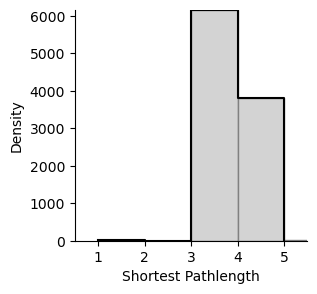

Saving figure ...
Saved!


In [33]:
node_index = 20
shortest_pathLength_distribution = shortest_pathlength_distribution[node_index]["shortest_pathLength_distribution"]
node_type = shortest_pathlength_distribution[node_index]["node_type"]
print(node_type)
shortest_pathLength_distribution = list(filter(None, shortest_pathLength_distribution))


FIG_SIZE = (3,3)
FONTSIZE = 10

# assuming shortest_pathLength_distribution is a list of discrete values
fig, ax = plt.subplots(figsize=FIG_SIZE)

# create a histogram with the specified bins
n, bins, patches = ax.hist(shortest_pathLength_distribution, bins=range(min(shortest_pathLength_distribution), max(shortest_pathLength_distribution)+2), edgecolor='gray', color="lightgray", alpha=1)

# set the height of each patch to the corresponding bin value
for i in range(len(patches)):
    patches[i].set_height(n[i])

# create a step-like curve for the outline
outline, = ax.step(bins[:-1], n, where='post', color='black')

ax.set_xlabel('Shortest Pathlength', fontsize=FONTSIZE)
ax.set_ylabel('Density', fontsize=FONTSIZE)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# set the limits and labels of the x and y axes
ax.set_xlim([min(shortest_pathLength_distribution)-0.5, max(shortest_pathLength_distribution)+0.5])
ax.set_ylim([0, max(n)+1])


plt.show()

print("Saving figure ...")
filename = "shortest_pathlength_distribution_{}_nodetype.svg".format(node_type)
fig.savefig(os.path.join(OUTPUT_PATH, "after_spoke_compound_pruning", "figures", filename), format="svg", bbox_inches='tight')
print("Saved!")
